# EEG data examples

Here, we demonstrate `sbijax` using a complicated real world EEG data set.

In [22]:
import arviz as az
import jax
import numpy as np
import optax
import sbijax
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoLocator, MaxNLocator
from jax import numpy as jnp, random as jr
from jax._src.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax import distributions as tfd

In [23]:
import mne
import moabb

from jax.scipy.signal import welch
from moabb.datasets import Rodrigues2017

## EEG data

In [24]:
import tempfile
temp_dir = tempfile.TemporaryDirectory()

In [25]:
dataset = Rodrigues2017()
dataset.download(path=temp_dir.name, verbose=False)

In [26]:
raw = dataset._get_single_subject_data(subject=2)['0']['0']
raw = raw.filter(l_freq=3, h_freq=40, verbose=False)
raw = raw.resample(sfreq=128, verbose=False)

In [27]:
events = mne.find_events(raw=raw, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=8.0, baseline=None, verbose=False)
epochs = epochs.load_data().pick_channels(['Oz'])

Using data from preloaded Raw for 10 events and 1025 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [28]:
X_closed = epochs['closed'].get_data().squeeze()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_closed_db = 10 * np.log10(S_closed)

X_opened = epochs['open'].get_data().squeeze()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], nperseg=64, axis=1)
S_opened_db = 10 * np.log10(S_opened)

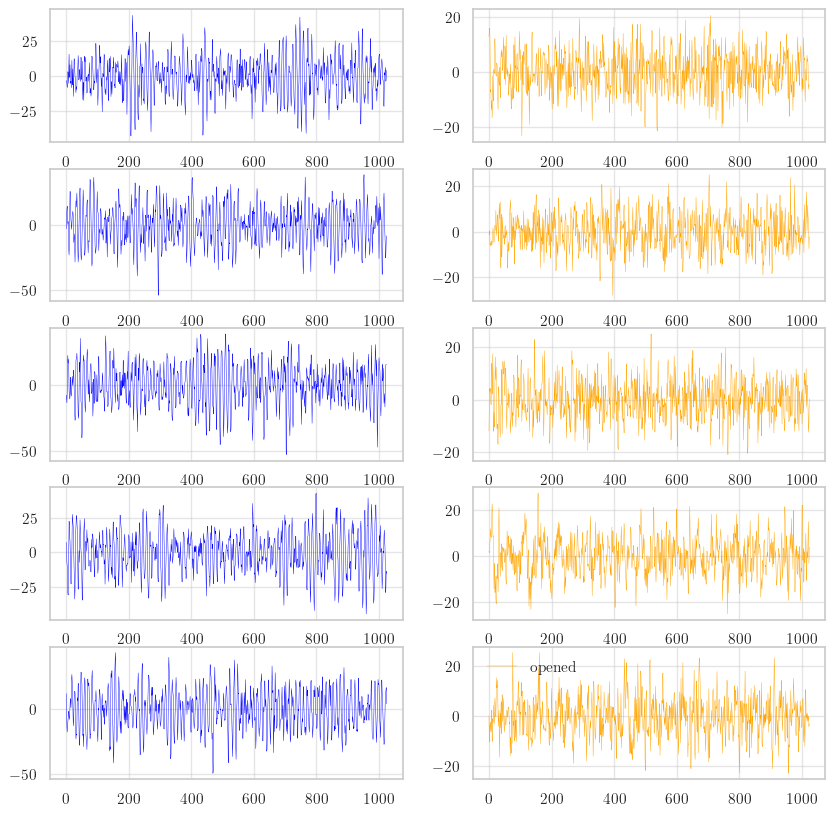

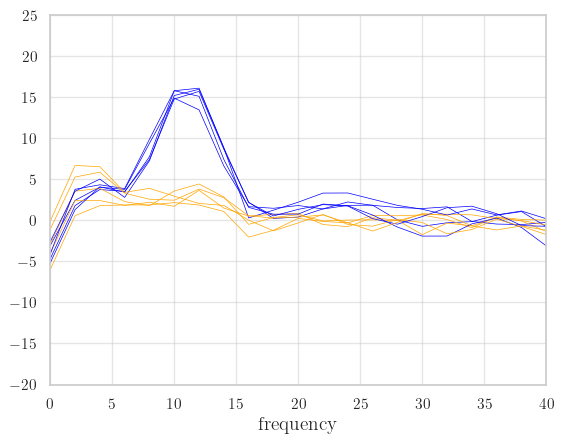

In [29]:
_, laxes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i in range(5):
    laxes[i, 1].plot(X_opened[i, :], color="orange", label="opened", linewidth=.31)        
    laxes[i, 0].plot(X_closed[i, :], color="blue", label="closed", linewidth=.31)
#laxes[2, 1].plot(X_opened[i, :], color="orange", label="opened", linewidth=.31)        
#laxes[2, 0].plot(X_closed[i, :], color="blue", label="closed", linewidth=.31)
#laxes[5, 1].plot(X_opened_mean, color="darkorange", label="opened", linewidth=.31)    
#laxes[5, 0].plot(X_closed_mean, color="darkblue", label="closed", linewidth=.31)    
plt.legend()
plt.show()

_, raxes = plt.subplots()
for i in range(5):
    raxes.plot(f, S_closed_db[i], color='blue', lw=.5)
    raxes.plot(f, S_opened_db[i], color='orange', lw=.5)
#raxes.plot(f, S_closed_db[2], color='blue', lw=.5)
#raxes.plot(f, S_opened_db[2], color='orange', lw=.5)
#raxes.plot(f, S_closed_db_mean, color='darkblue', lw=.5)
#raxes.plot(f, S_opened_db_mean, color='darkorange', lw=.5)
raxes.set_xlim(0, 40)
raxes.set_ylim(-20, +25)
raxes.set_xlabel('frequency', fontsize=14)
plt.show()

## Prior and simulator

In [30]:
def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        C=tfd.Uniform(10.0, 250.0),
        mu=tfd.Uniform(50.0, 500.0),
        sigma=tfd.Uniform(100, 5000),
        gain=tfd.Uniform(-20, 20),
    ), batch_ndims=0)
    return prior

prior = prior_fn()

In [31]:
def jansen_rit_fn(len_timeseries=1025, t_end=8.0):
    import rpy2.robjects as robjects
    from rpy2.robjects.packages import importr   
    sdbmp = importr("sdbmsABC")

    rset_seed = robjects.r["set.seed"]
    rchol = robjects.r["chol"]
    rt = robjects.r["t"]
    
    A = 3.25
    B = 22.0
    a = 100.0
    b = 50.0
    vmax = 5.0
    v0 = 6.0
    r = 0.56
    sigma4 = 0.01
    sigma6 = 1
    
    burnin = 0.0
    h = 1 / 128 # sampling rate is 1/F where F=128
    grid = robjects.FloatVector(list(np.arange(0, t_end + burnin + h, h)))
    def fn(seed, theta):        
        rset_seed(int(np.sqrt(seed[0])))
        C, mu, sigma, gain = theta.tolist()
        gain_abs = 10 ** (gain / 10)        
        y0 = robjects.FloatVector(list([0.08, 18, 15, -0.5, 0, 0]))
        dm = sdbmp.exp_matJR(h, a, b)                
        cm = rt(
            rchol(sdbmp.cov_matJR(h, robjects.FloatVector([0, 0, 0, sigma4, sigma, sigma6]), a, b))
        )        
        yt = gain_abs * jnp.array(
            sdbmp.Splitting_JRNMM_output_Cpp(
                h, y0, grid, dm, cm, mu, C, A, B, a, b, v0, r, vmax
            )
        )       
        yt = yt[int(burnin/h):]
        return yt - np.mean(yt)

    return fn

In [32]:
simulate_jansen_rit = jansen_rit_fn(len_timeseries=1025, t_end=8.0)

In [33]:
def simulator(seed, theta, len_timeseries=1025, t_end=8.0):    
    Cs, mus, sigmas, gains = theta["C"], theta["mu"], theta["sigma"], theta["gain"]
    seeds = jr.split(seed, Cs.shape[0])
    
    # get length of y
    simulate_jansen_rit = jansen_rit_fn(len_timeseries=len_timeseries, t_end=t_end)
    y = simulate_jansen_rit(seed, np.array([Cs[0], mus[0], sigmas[0], gains[0]]))
    
    ys = np.zeros((Cs.shape[0], len(y)))
    for i, (C, mu, sigma, gain, seed) in enumerate(zip(Cs, mus, sigmas, gains, seeds)):        
        y = simulate_jansen_rit(seed, np.array([C, mu, sigma, gain]))
        ys[i] = np.array(y)
    return ys

In [34]:
def get_experimental_data(prior):
    import os
    import pickle

    fl = "../../../../results/eeg_data.pkl"
    if os.path.exists(fl):
        print("loading precomputed data")
        with open(fl, 'rb') as handle:
            di = pickle.load(handle)
        return di

    # synthetic data example
    theta_synthetic = np.array([135, 220, 2000, 0])
    y_synthetic = simulate_jansen_rit(jr.PRNGKey(1), theta_synthetic)
    y_synthetic = np.array(y_synthetic)

    # experimental data
    y_experimental_closed = X_closed[[2]]
    y_experimental_opened = X_opened[[2]]    

    # simulations
    n = 100_000
    theta_train = prior.sample(seed=jr.PRNGKey(2), sample_shape=(n,))
    y_train = simulator(jr.PRNGKey(3), theta_train)
    with open(fl, 'wb') as handle:
        di = dict(
            theta_synthetic=theta_synthetic, 
            y_synthetic=y_synthetic, 
            y_experimental_closed=y_experimental_closed, 
            y_experimental_opened=y_experimental_opened,
            theta_train=theta_train, 
            y_train=y_train
        )        
        pickle.dump(
            di, 
            handle, 
            protocol=pickle.HIGHEST_PROTOCOL
        )
    
    return di

eeg_data = get_experimental_data(prior)

loading precomputed data


# Summary statistics

In [35]:
def summarize(y, n_summaries=33, fs=epochs.info['sfreq']):
    _, summaries = welch(y, fs=fs, nperseg=2 * (n_summaries - 1), axis=1)
    return summaries

In [36]:
summaries_train = summarize(eeg_data["y_train"])

# Flow matching posterior estimation

In [37]:
from sbijax import FMPE, NLE, NPE
from sbijax.nn import make_cnf, make_maf

In [38]:
n_layers, hidden_size = 10, 128
n_dim_theta = 4
neural_network = make_cnf(n_dim_theta, n_layers, hidden_size)

fns = prior_fn, None
estim = FMPE(fns, neural_network)

In [44]:
n_dim_data = 33
n_dim_theta = 4
n_layers, hidden_sizes = 10, (64, 64)
neural_network = make_maf(n_dim_theta, n_layers, hidden_sizes=hidden_sizes)

fns = prior_fn, None
estim = NPE(fns, neural_network)

In [45]:
data = {"y": summaries_train, "theta": eeg_data["theta_train"]}
params, info = estim.fit(
    jr.PRNGKey(1),
    data=data,
    optimizer=optax.adam(0.0001),
    n_early_stopping_delta=0.00001,
    n_early_stopping_patience=30,
)

 50%|██████████████████████████████████████████████████████████████████████▏                                                                    | 505/1000 [14:15<13:58,  1.69s/it]


# Synthetic data example

In [46]:
posterior, diagnostics = estim.sample_posterior(
    jr.PRNGKey(2), 
    params,
    observable=summarize(eeg_data["y_synthetic"].reshape(1, -1)),    
    n_samples=10_000,    
)

In [47]:
eeg_data["theta_synthetic"]

array([ 135,  220, 2000,    0])

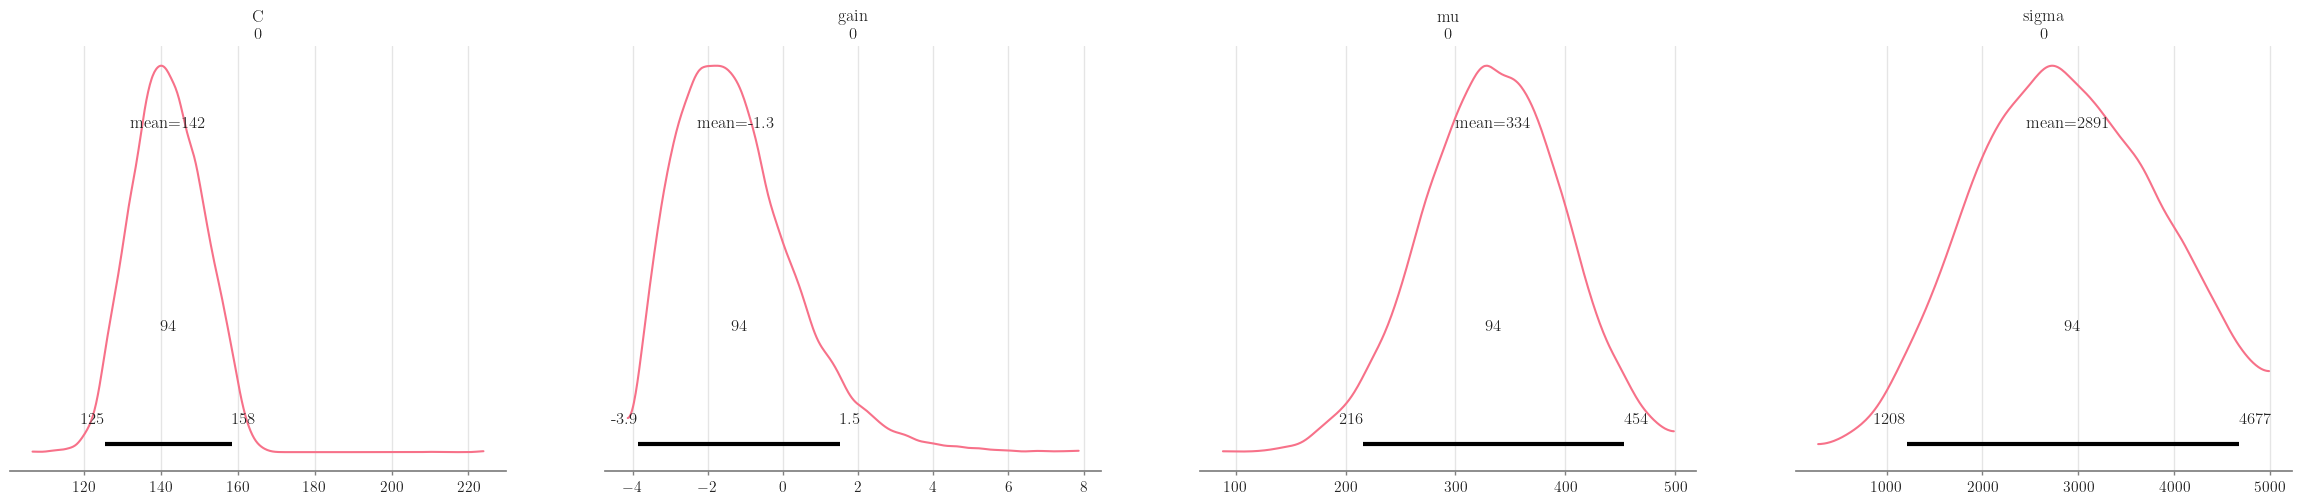

In [48]:
az.plot_posterior(posterior)
plt.show()

## Real data

In [49]:
posterior_open, diagnostics = estim.sample_posterior(
    jr.PRNGKey(2), 
    params,
    observable=summarize(eeg_data["y_experimental_opened"]),
    n_samples=10_000,    
)

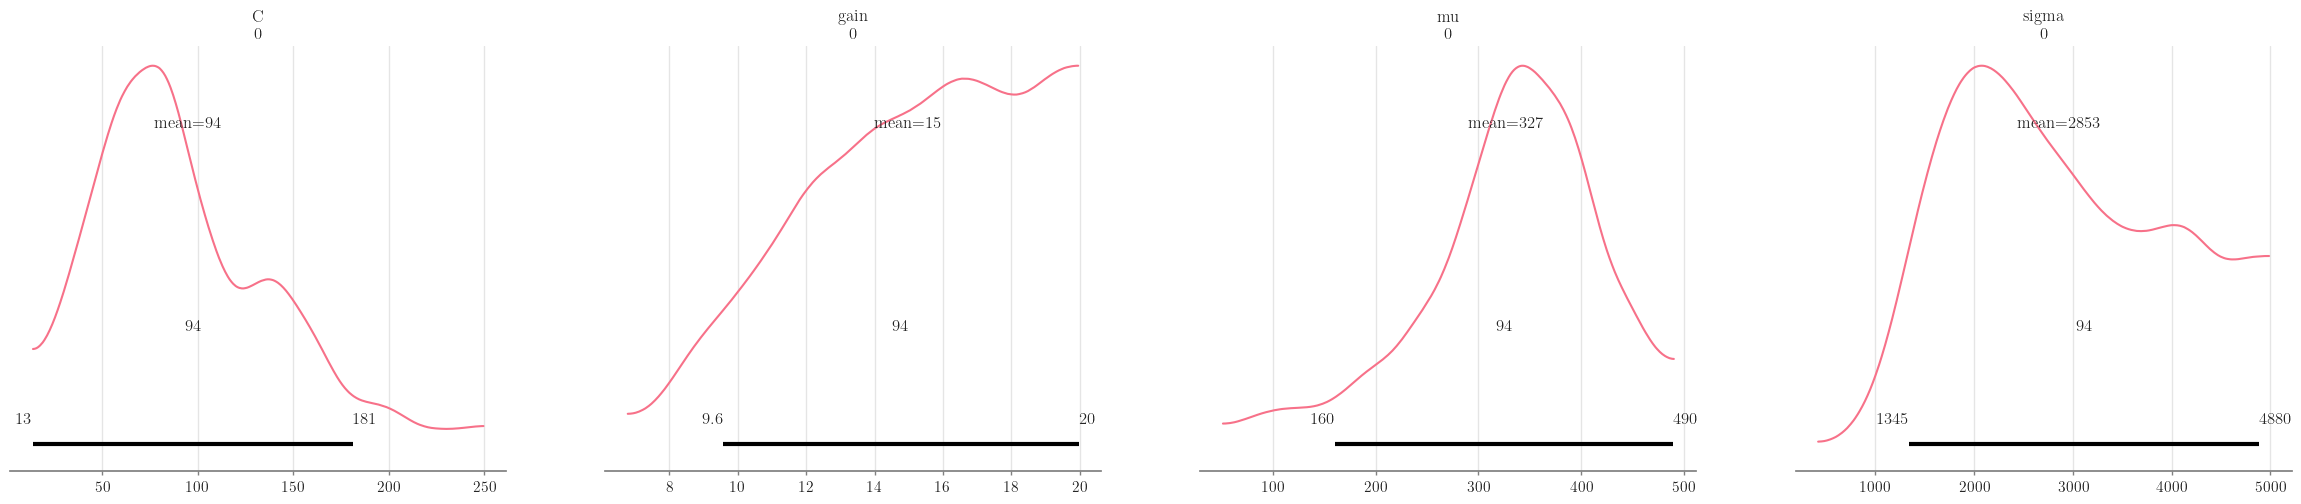

In [51]:
az.plot_posterior(posterior_open)
plt.show()

In [52]:
posterior_closed, diagnostics = estim.sample_posterior(
    jr.PRNGKey(2),
    params,
    observable=summarize(eeg_data["y_experimental_closed"]),    
    n_samples=10_000,    
)

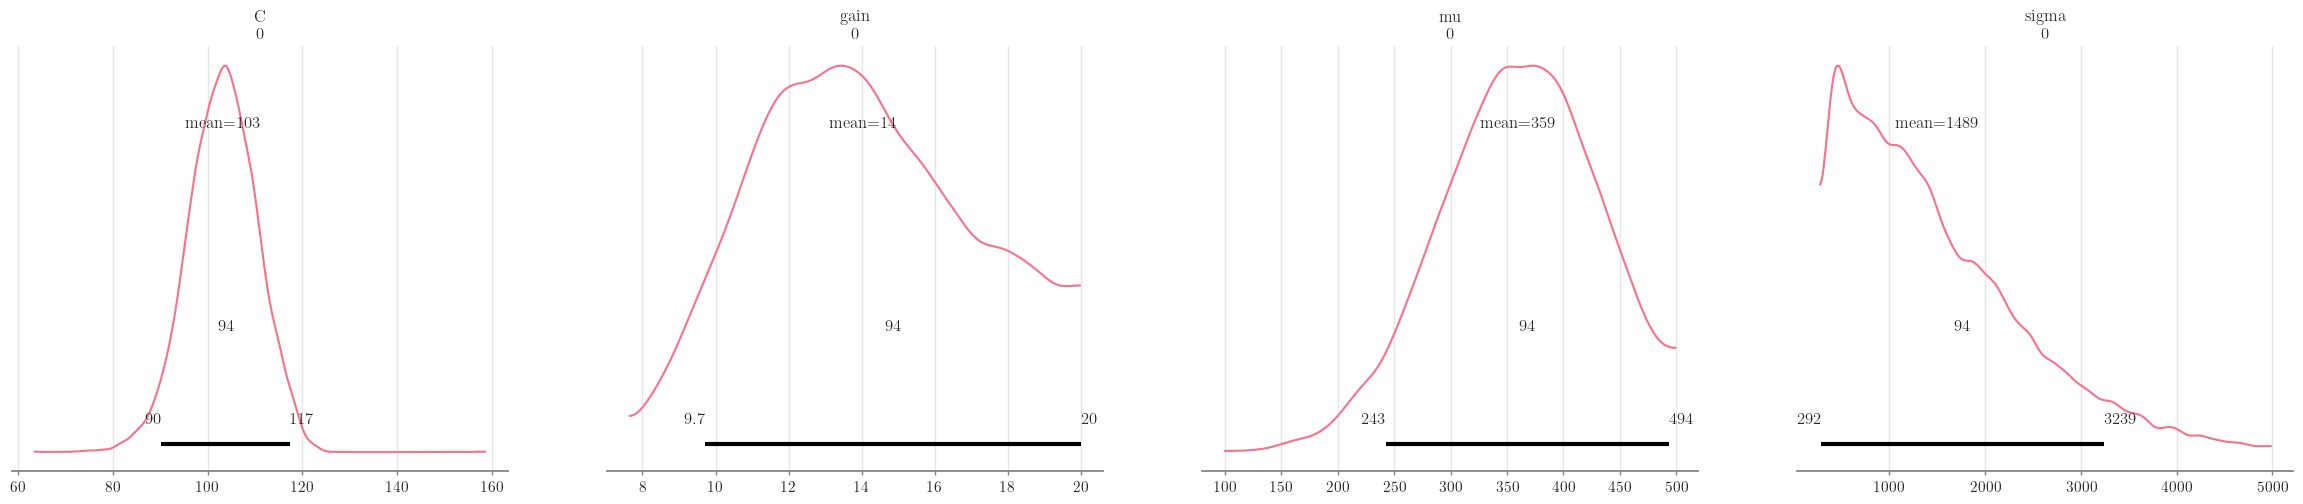

In [53]:
az.plot_posterior(posterior_closed)
plt.show()

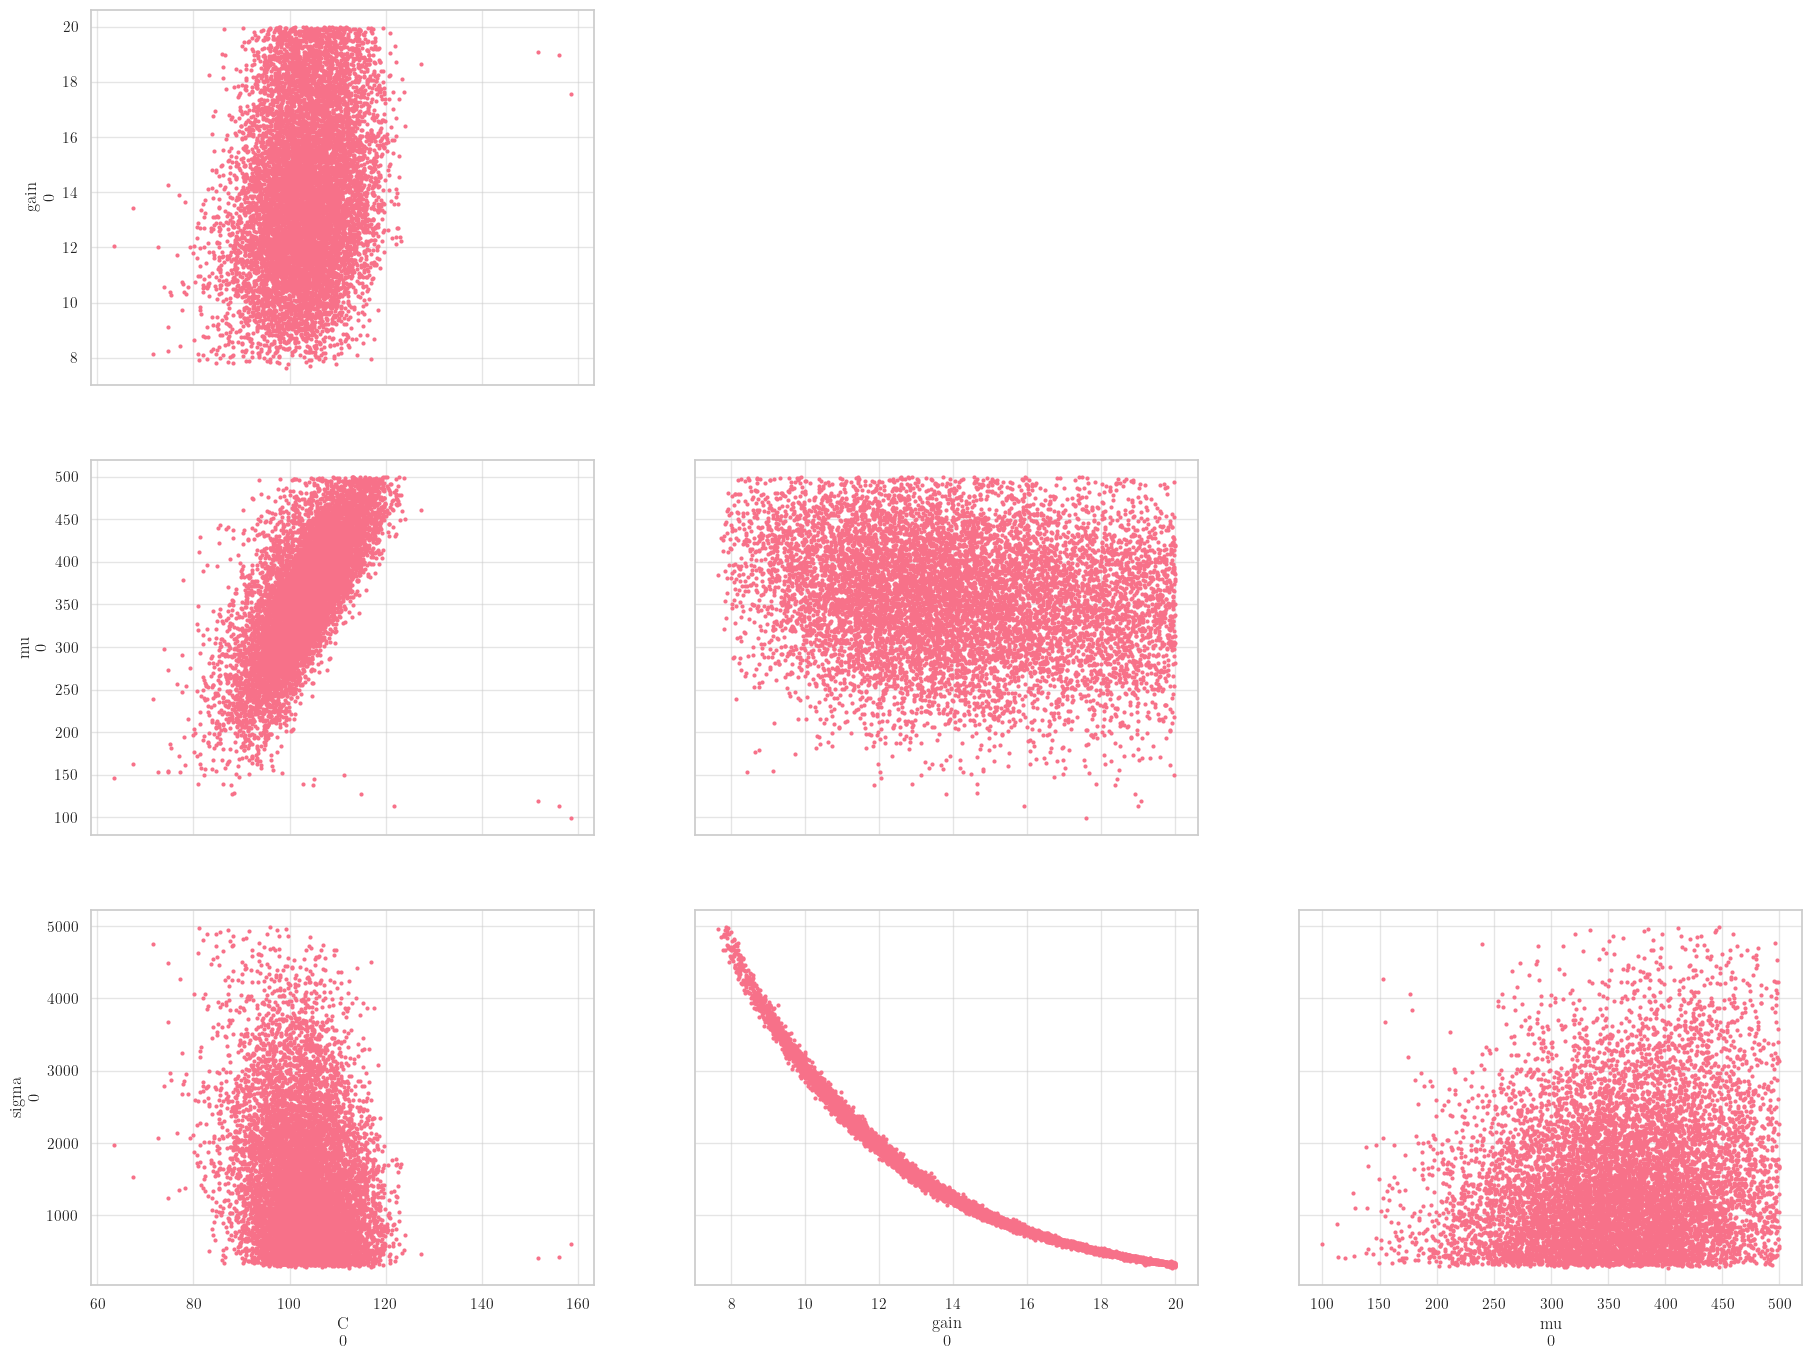

In [56]:
az.plot_pair(posterior_closed)
plt.show()

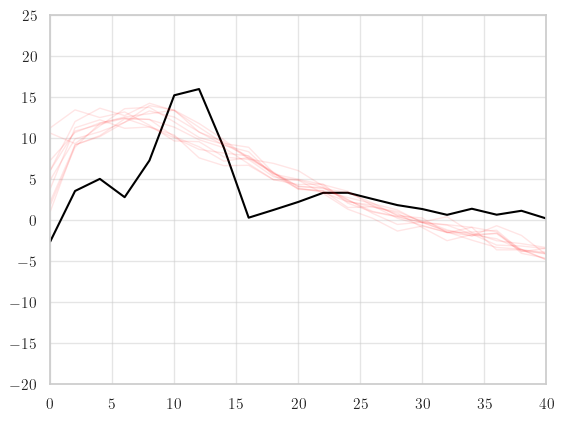

In [122]:
f, s = welch(X_closed, fs=epochs.info['sfreq'], nperseg=64, axis=1)
s = 10 * np.log10(s)
plt.plot(f, s[2], color="black")
sss = 10 * np.log10(summarize(ppd))
for i in range(10):
   plt.plot(f, sss[i], color="red", linewidth=1, alpha=.1)
plt.ylim(-20, +25)
plt.xlim(0, 40)
plt.show()